In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib  as mpl
import h5py
import matplotlib.colors as colors
from tqdm import tqdm
from scipy import stats
import cmasher as cmr
import seaborn as sns
import warnings
import multiprocessing as mp
from functools import partial
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

from matplotlib.colors import Normalize

import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

from matplotlib.colors import LogNorm

In [2]:
from msafit.model.config import get_default_config
params = get_default_config()
params['instrument']['filter'] = "F170LP"
params['instrument']['disperser'] = "G235H"

#ofr detectors if Z= 4 G395H and F290LP if Z = 2 G235H and F170LP
from msafit.fpa import PSFLib
psfs = PSFLib('1x3_G235H_Q3_PSFLib.fits')
params["grid"]["x_grid"] = psfs.psf_x
params["grid"]["y_grid"] = psfs.psf_y
params["grid"]["wave_grid"] = psfs.psf_wave

from msafit.model import Sersic
# create a model cube I(x,y,lambda)
model = Sersic(params)
model(params["grid"]["wave_grid"])

_param_dict = model._param_dict
x_grid_bins = _param_dict['grid']['x_grid_sky'][0,:]
y_grid_bins = _param_dict['grid']['y_grid_sky'][:,0]

In [3]:
def Gal_inf (ID,Snap,offset_x,offset_y):

    file_path = f'/virgotng/universe/IllustrisTNG/TNG50-1/output/snapdir_{Snap:03d}/snap_{Snap:03d}.0.hdf5'
    
    with h5py.File(file_path, 'r') as f:
        header = dict( f['Header'].attrs.items())
        
    z = header['Redshift']

    scaling_factor = 1.0 / (1+z)

    hubble_param = header['HubbleParam']
    H0 = hubble_param*100
    Omega_lamb = header['OmegaLambda']
    Omega_baryon = header['OmegaBaryon']
    Omega_0 = header['Omega0']

    basePath = "/virgotng/universe/IllustrisTNG/TNG50-1/output"

    Subhalo = il.groupcat.loadSingle(basePath,Snap, subhaloID = ID)

    Subhalo_gas_part = il.snapshot.loadSubhalo(basePath, snapNum=Snap, id=ID, partType='gas', fields=["StarFormationRate","Masses","Coordinates","Velocities"])

    Starforming_cond = Subhalo_gas_part["StarFormationRate"] > 0

    Coord_gas = (Subhalo_gas_part["Coordinates"][Starforming_cond]-Subhalo["SubhaloPos"]) * scaling_factor / hubble_param
    
    Coord_gas[:,0] = Coord_gas[:,0]  + offset_x

    Coord_gas[:,1] = Coord_gas[:,1]  + offset_y
    
    radius = np.sqrt(np.sum(Coord_gas**2, axis=1))
    
    Rad_cond  = radius < (0.4*Subhalo["SubhaloHalfmassRadType"][0])
    
    velocity_gas = ((Subhalo_gas_part["Velocities"][Starforming_cond])[:,2]*np.sqrt(scaling_factor)) - Subhalo["SubhaloVel"][2]

    SFR = Subhalo_gas_part["StarFormationRate"][Starforming_cond]
    
    return(Coord_gas[Rad_cond],velocity_gas[Rad_cond],SFR[Rad_cond],Omega_0, Omega_lamb, Omega_baryon, H0, z)


def Distances(Omega_0, Omega_baryon, H0, z):

    cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_0, Ob0=Omega_baryon)

    D_A = cosmo.angular_diameter_distance(z).to(u.Mpc)

    D_A_kpc = D_A.to(u.kpc)

    D_L = cosmo.luminosity_distance(z)

    D_A_val = D_A_kpc.value

    D_L = D_L.value
    
    return(D_A_val,D_L)


def Flux(SFR,Dl):

    L_sun_erg_per_s = 3.828e33

    L_Halpha = SFR/np.float64(7.9e-42*L_sun_erg_per_s) #Lo

    D_l = Dl  * 3.08567758e24 #Mpc to cm

    FHalpha = (L_Halpha / (4*np.pi*(D_l**2))) * L_sun_erg_per_s # erg.cm-2

    return (FHalpha)

def Delta_Lambda(v_z,z):
    
    H_alpha_wave = 6564.6 * (1+z) #Ångström

    c = 299792 #km/s

    delt_lamb = (v_z/c)*H_alpha_wave

    return(delt_lamb)


def xy_bins(x_grid_bins,y_grid_bins,DA): 

    bin_widthx = np.abs(x_grid_bins[0]) - np.abs(x_grid_bins[1]) 
    bin_widthy = np.abs(y_grid_bins[0]) - np.abs(y_grid_bins[1]) 
    
    bin_edges_for_x =  []
    bin_edges_for_y =  []

    bin_edges_for_x.append(x_grid_bins[0] - bin_widthx / 2)
    bin_edges_for_y.append(y_grid_bins[0] - bin_widthy / 2)

    
    for center in x_grid_bins:
        bin_edges_for_x.append(center + bin_widthx / 2)

    for center in y_grid_bins:
        bin_edges_for_y.append(center + bin_widthy / 2)

    bin_edges_for_x = np.array(bin_edges_for_x)
    bin_edges_for_y = np.array(bin_edges_for_y)
    
    angular_res_rad_x = bin_edges_for_x * (np.pi/(180*3600))

    angular_res_rad_y = bin_edges_for_y * (np.pi/(180*3600))

    Bin_edges_kpc_x = angular_res_rad_x * DA # d = theta * DA in kpc

    Bin_edges_kpc_y = angular_res_rad_y * DA # d = theta * DA in kpc

    return(Bin_edges_kpc_x,Bin_edges_kpc_y)


def Bins(v_z,speed_bin_size,x_bin,y_bin):

    bin_width_vz = speed_bin_size
    vz_min = np.nanmin(v_z)
    vz_max = np.nanmax(v_z)

    num_bins_v_z = int(np.ceil((vz_max - vz_min) / bin_width_vz))
    bin_edges_v_z = np.linspace(vz_min, vz_max, num_bins_v_z + 1)

    bin_centers_v_z = (bin_edges_v_z[:-1] + bin_edges_v_z[1:]) / 2
    
    Bin_edges = [x_bin,y_bin,bin_edges_v_z]
    
    return (Bin_edges,bin_centers_v_z)   


def Cube_maker (Coord,Lambda,flux,Bin_edges) :
    # Digitize the coordinates
    x_indices = np.digitize(Coord[:,1], Bin_edges[0]) - 1  # Subtract 1 to get zero-based index
    y_indices = np.digitize(Coord[:,0], Bin_edges[1]) - 1  # Subtract 1 to get zero-based index
    delta_lambda_indices = np.digitize(Lambda, Bin_edges[2]) - 1  # Subtract 1 to get zero-based index

    nb_x_bins = len(Bin_edges[0]) - 1
    nb_y_bins = len(Bin_edges[1]) - 1
    nb_delta_lambda_bins = len(Bin_edges[2]) - 1
    
    # Create the 3D array for accumulating flux values
    cube_3d = np.zeros((nb_x_bins, nb_y_bins, nb_delta_lambda_bins))
    
    # Accumulate flux into the bins
    for i in range(len(Coord[:,0])):
        if 0 <= x_indices[i] < nb_x_bins and 0 <= y_indices[i] < nb_y_bins and 0 <= delta_lambda_indices[i] < nb_delta_lambda_bins:
            cube_3d[x_indices[i], y_indices[i], delta_lambda_indices[i]] += flux[i]
    
    return (cube_3d)


def pipeline(ID, Snap, offset_x = 0, offset_y=0):
    speed_bin_size = float(input("Enter the bin size of speed in (km/s): "))
    
    Coord_gas,velocity_gas,SFR,Omega_0, Omega_lamb, Omega_baryon, H0, Z = Gal_inf(ID,Snap,offset_x,offset_y)
    DA,Dl = Distances(Omega_0, Omega_baryon, H0, Z)
    FHalpha = Flux(SFR,Dl)
    x_bin,y_bin = xy_bins(x_grid_bins,y_grid_bins,DA)
    Bin_edges,bin_centers_v_z = Bins(velocity_gas,speed_bin_size,x_bin,y_bin)
    Lambda = Delta_Lambda(velocity_gas,Z)
    bin_edges_lambda = Delta_Lambda(Bin_edges[2],Z)
    bin_centers_lambda = Delta_Lambda(bin_centers_v_z,Z)
    Bin_edges[2] = bin_edges_lambda
    cube = Cube_maker(Coord_gas,Lambda,FHalpha,Bin_edges)
    
    return(Coord_gas,cube,Bin_edges,bin_centers_lambda,Z)

In [4]:
ID = 125843
Snap = 33
#Snap_nums = [99, 50, 33, 25, 21, 17, 13] #z = 0,1,2,3,4,5,6

offset_x = 0
offset_y = 0

Coord_gas,cube,Bin_edges,bin_centers_lambda,Z = pipeline(ID,Snap,offset_x,offset_y)

Enter the bin size of speed in (km/s):  10


In [5]:
Squished_cube = np.nansum(cube, axis=2)
Squished_cube_x_lamb = np.nansum(cube, axis=1)
Total_flux = np.nansum(Squished_cube)
Mean_flux = np.nanmean(Squished_cube)

In [6]:
Bin_edges[0]

array([-2.40509942, -2.19596034, -1.98682126, -1.77768218, -1.5685431 ,
       -1.35940402, -1.15026494, -0.94112586, -0.73198678, -0.5228477 ,
       -0.31370862, -0.10456954,  0.10456954,  0.31370862,  0.5228477 ,
        0.73198678,  0.94112586,  1.15026494,  1.35940402,  1.5685431 ,
        1.77768218,  1.98682126,  2.19596034,  2.40509942])

In [7]:
Bin_edges[0][-1]

2.4050994213578054

In [8]:
Bin_edges[1][0]

-8.294189391215228

In [9]:
Bin_edges[1][-1]

8.294189391215228

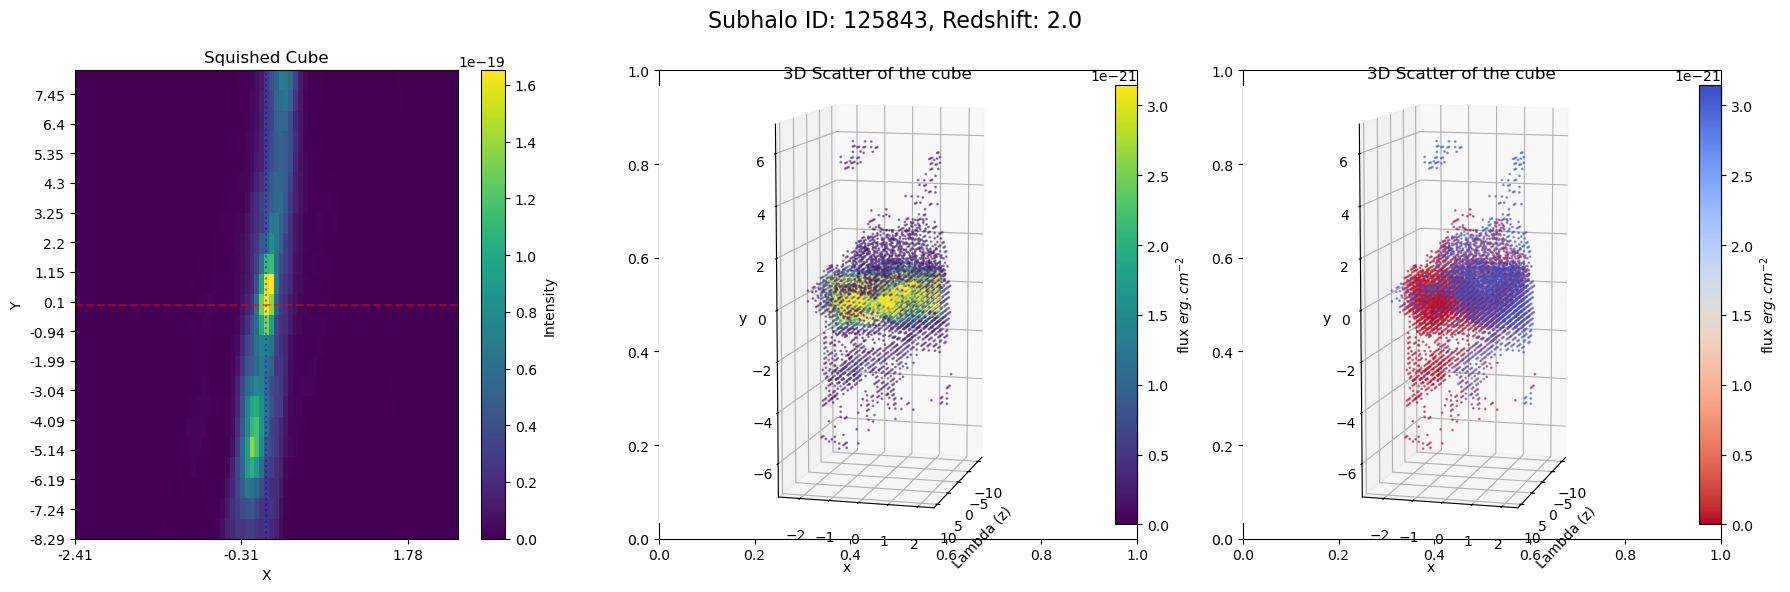

In [10]:
# Extracting one value per row from Squished_cube
extracted_values = Squished_cube[:, 0]

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Squished_cube on the left subplot
extent = [Bin_edges[0][0], Bin_edges[0][-1], Bin_edges[1][0], Bin_edges[1][-1]]

im = axes[0].imshow(Squished_cube, cmap='viridis', aspect='auto', extent=extent, origin='lower')
axes[0].set_title('Squished Cube')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Setting x and y ticks to the actual bin edges
axes[0].set_xticks(Bin_edges[0][::10])  # Adjust the step as needed for readability
axes[0].set_xticklabels(np.round(Bin_edges[0][::10], 2))
axes[0].set_yticks(Bin_edges[1][::5])  # Adjust the step as needed for readability
axes[0].set_yticklabels(np.round(Bin_edges[1][::5], 2))
axes[0].grid(False)
axes[0].axhline(y=0, color='red', linestyle='--',alpha=0.5)   # Vertical line at x = 0
axes[0].axvline(x=0, color='blue', linestyle=':',alpha=0.5) # Vertical line at x = 0.5

cbar0 = plt.colorbar(im, ax=axes[0], label='Intensity')  # Add a color bar to show the mapping of values to colors

ax1 = fig.add_subplot(1, 3, 2, projection='3d')

# Find the non-zero elements in the cube
x, y, z = np.nonzero(cube)
flux_cube = cube[x, y, z]  # Flux values

# Normalize the flux values for color mapping
norm = Normalize(vmin=0, vmax=np.percentile(flux_cube, 80))

# Convert indices to corresponding bin edges
x_vals = Bin_edges[0][x]
y_vals = Bin_edges[1][y]
z_vals = Bin_edges[2][z]

# Plot scatter points with colormap
scatter = ax1.scatter(z_vals, x_vals, y_vals, c=flux_cube, cmap='viridis', s=1, alpha=0.5, norm=norm)
ax1.set_title('3D Scatter of the cube')
ax1.set_xlabel('Lambda (z)')
ax1.set_ylabel('x')
ax1.set_zlabel('y')

# Set the aspect ratio for the plot (length, width, height)
ax1.set_box_aspect([4, 3, 7])  # Adjust this as needed

# Add color bar for the scatter plot
cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label(r'flux $erg.cm^{-2}$')

# Adjusting the viewing angle
ax1.view_init(elev=10, azim=15)


ax2 = fig.add_subplot(1, 3, 3, projection='3d')

# Find the non-zero elements in the cube
x, y, z = np.nonzero(cube)
flux_cube = cube[x, y, z]  # Flux values

# Normalize the flux values for color mapping
norm = Normalize(vmin=0, vmax=np.percentile(flux_cube, 80))

# Convert indices to corresponding bin edges
x_vals = Bin_edges[0][x]
y_vals = Bin_edges[1][y]
z_vals = Bin_edges[2][z]

# Plot scatter points with colormap
scatter = ax2.scatter(z_vals, x_vals, y_vals, c=Bin_edges[2][z], cmap='coolwarm_r', s=1, alpha=0.5, norm=norm)
ax2.set_title('3D Scatter of the cube')
ax2.set_xlabel('Lambda (z)')
ax2.set_ylabel('x')
ax2.set_zlabel('y')

# Set the aspect ratio for the plot (length, width, height)
ax2.set_box_aspect([4, 3, 7])  # Adjust this as needed

# Add color bar for the scatter plot
cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm_r'), ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label(r'flux $erg.cm^{-2}$')

# Adjusting the viewing angle
ax2.view_init(elev=10, azim=15)

# Add the main title
fig.suptitle(f'Subhalo ID: {ID}, Redshift: {Z:.1f}', fontsize=16)

plt.tight_layout()
plt.show()

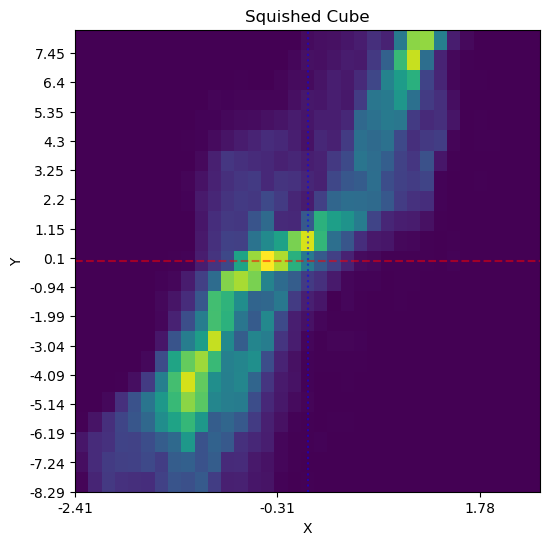

In [11]:
# Create a subplot with 1 row and 3 columns
fig, ax = plt.subplots(figsize=(6, 6))

# Plot Squished_cube on the left subplot
extent = [Bin_edges[0][0], Bin_edges[0][-1], Bin_edges[1][0], Bin_edges[1][-1]]

im = ax.imshow(Squished_cube_x_lamb, cmap='viridis', aspect='auto', extent=extent, origin='lower')
ax.set_title('Squished Cube')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Setting x and y ticks to the actual bin edges
ax.set_xticks(Bin_edges[0][::10])  # Adjust the step as needed for readability
ax.set_xticklabels(np.round(Bin_edges[0][::10], 2))
ax.set_yticks(Bin_edges[1][::5])  # Adjust the step as needed for readability
ax.set_yticklabels(np.round(Bin_edges[1][::5], 2))
ax.grid(False)
ax.axhline(y=0, color='red', linestyle='--',alpha=0.5)   # Vertical line at x = 0
ax.axvline(x=0, color='blue', linestyle=':',alpha=0.5) # Vertical line at x = 0.5

cbar0 = plt.colorbar(im, ax=axes[0], label='Intensity')  # Add a color bar to show the mapping of values to colors


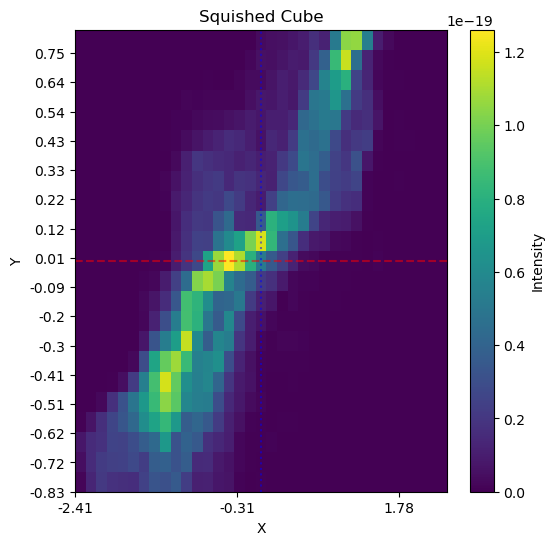

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Bin_edges and Squished_cube_x_lamb are already defined
# Convert kpc to pixels
Bin_edges_pixels = [edge * 10 for edge in Bin_edges[1]]

# Create a subplot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot Squished_cube on the left subplot
extent = [Bin_edges[2][0], Bin_edges[2][-1], Bin_edges_pixels[0], Bin_edges_pixels[-1]]
im = ax.imshow(Squished_cube_x_lamb, cmap='viridis', aspect='auto', extent=extent, origin='lower')
ax.set_title('Squished Cube')
ax.set_xlabel(r'$\Delta\lambda$')
ax.set_ylabel('Y (pixels)')

# Setting x and y ticks to the actual bin edges
ax.set_xticks(Bin_edges[2][::5])  # Adjust the step as needed for readability
ax.set_xticklabels(np.round(Bin_edges[2][::5], 2))

# Adjust y-ticks for pixels
ax.set_yticks(Bin_edges_pixels[::5])  # Adjust the step as needed for readability
ax.set_yticklabels(np.round(Bin_edges_pixels[::5], 2))
ax.grid(False)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Horizontal line at y = 0
ax.axvline(x=0, color='blue', linestyle=':', alpha=0.5)  # Vertical line at x = 0

cbar0 = plt.colorbar(im, ax=ax, label='Intensity')  # Add a color bar to show the mapping of values to colors

plt.show()

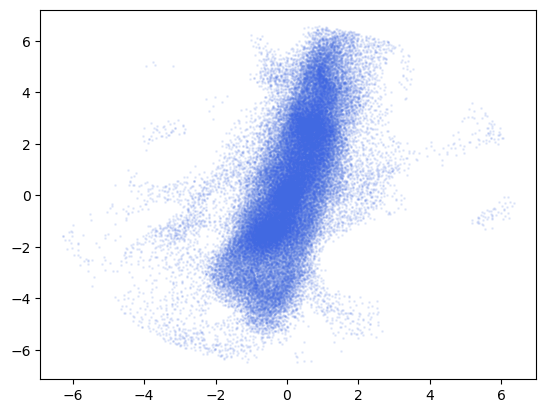

In [13]:
plt.scatter(Coord_gas[:,0],Coord_gas[:,1],s=1, color = "royalblue",alpha = 0.1)

In [14]:
np.save('/u/flolac/Cube_datas/cube_data.npy', cube)
np.savez('/u/flolac/Cube_datas/Bin_edges.npz', x=Bin_edges[0], y=Bin_edges[1], lambda_=Bin_edges[2])
np.save('/u/flolac/Cube_datas/bin_centers_lambda.npy', bin_centers_lambda)

In [15]:
bin_centers_lambda

array([-10.16600771,  -9.52555875,  -8.8851098 ,  -8.24466084,
        -7.60421188,  -6.96376293,  -6.32331397,  -5.68286501,
        -5.04241606,  -4.4019671 ,  -3.76151815,  -3.12106919,
        -2.48062023,  -1.84017128,  -1.19972232,  -0.55927336,
         0.08117559,   0.72162455,   1.36207351,   2.00252246,
         2.64297142,   3.28342037,   3.92386933,   4.56431829,
         5.20476724,   5.8452162 ,   6.48566516,   7.12611411,
         7.76656307,   8.40701203,   9.04746098,   9.68790994,
        10.32835889,  10.96880785,  11.60925681])